# Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [2]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    sigma = ds.sigma_theta
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, sigma, date, mask)


# Masking

In [3]:
def masking (depth, temp, saline, sigma, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)
    sigma = sigma.where(mask[0,depth]==1)

    return (temp, saline, sigma)


# SOM

In [4]:
def som (depth, temp, saline, sigma):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten(), sigma[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [5]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [6]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,                    
                    )
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.set_title('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('SOM clustering using temperature, salinity and sigma-t for ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 11775 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.04 degrees Celsius
The mean temperature for cluster 0 is 9.02 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 22.83 g/kg
The mean salinity for cluster 0 is 17.48 g/kg 


The amount of grid boxes for cluster 1 is 13711 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 9.0 degrees Celsius 

The minimum salinity for cluster 1 is 24.93 g/kg
The maximum salinity for cluster 1 is 26.98 g/kg
The mean salinity for cluster 1 is 26.09 g/kg 


The amount of grid boxes for cluster 2 is 9896 

The minimum temperature for cluster 2 is 7.08 degrees Celsius
The maximum temperature for cluster 2 is 9.85 degrees Celsius
The mean temperature for cluster 2 is 8.48 degrees Celsius 

The

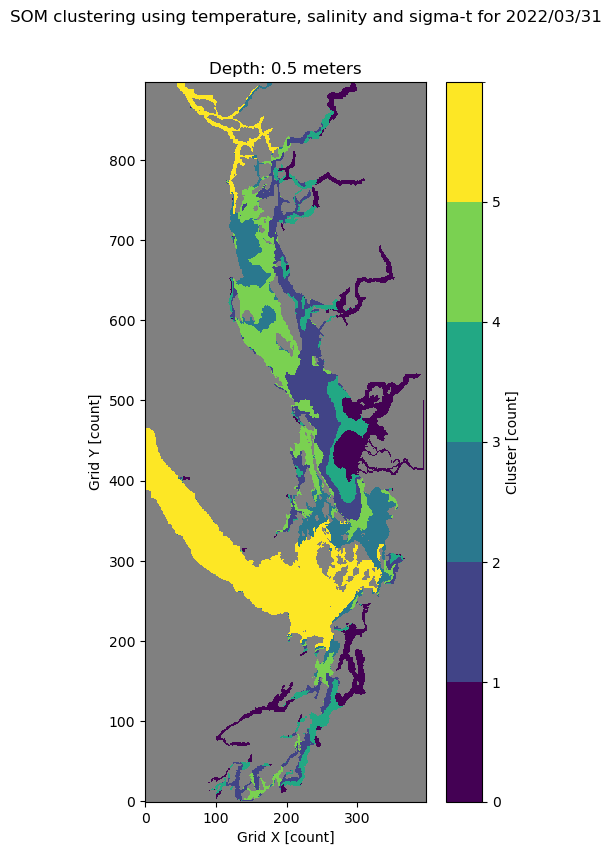

The amount of grid boxes for cluster 0 is 26797 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 9.72 degrees Celsius
The mean temperature for cluster 0 is 7.99 degrees Celsius 

The minimum salinity for cluster 0 is 28.87 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.34 g/kg 


The amount of grid boxes for cluster 1 is 10776 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.0 degrees Celsius
The mean temperature for cluster 1 is 8.66 degrees Celsius 

The minimum salinity for cluster 1 is 26.79 g/kg
The maximum salinity for cluster 1 is 28.27 g/kg
The mean salinity for cluster 1 is 27.58 g/kg 


The amount of grid boxes for cluster 2 is 6898 

The minimum temperature for cluster 2 is 7.26 degrees Celsius
The maximum temperature for cluster 2 is 10.54 degrees Celsius
The mean temperature for cluster 2 is 9.15 degrees Celsius 

T

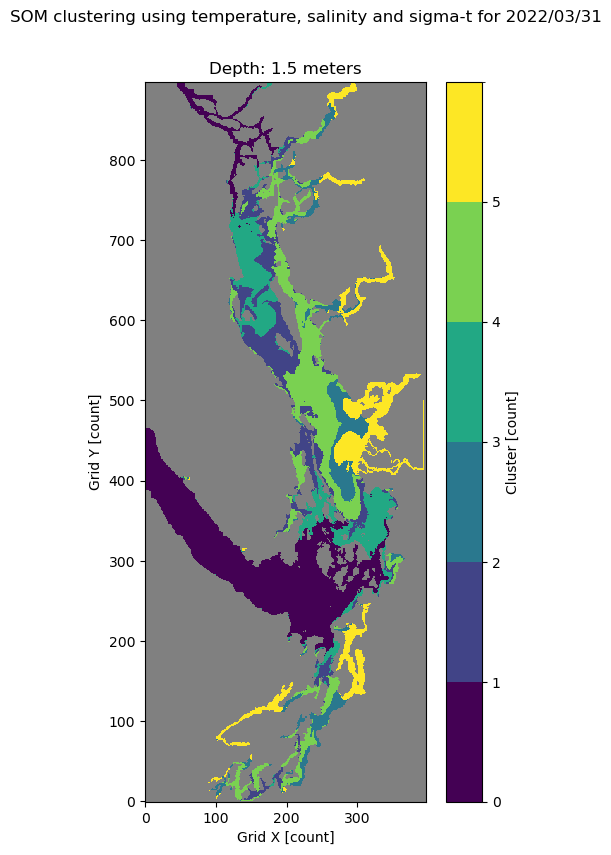

The amount of grid boxes for cluster 0 is 7825 

The minimum temperature for cluster 0 is 7.62 degrees Celsius
The maximum temperature for cluster 0 is 10.52 degrees Celsius
The mean temperature for cluster 0 is 9.03 degrees Celsius 

The minimum salinity for cluster 0 is 23.85 g/kg
The maximum salinity for cluster 0 is 26.1 g/kg
The mean salinity for cluster 0 is 25.09 g/kg 


The amount of grid boxes for cluster 1 is 15279 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 8.77 degrees Celsius 

The minimum salinity for cluster 1 is 25.8 g/kg
The maximum salinity for cluster 1 is 27.68 g/kg
The mean salinity for cluster 1 is 26.69 g/kg 


The amount of grid boxes for cluster 2 is 13001 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 9.83 degrees Celsius
The mean temperature for cluster 2 is 8.43 degrees Celsius 

Th

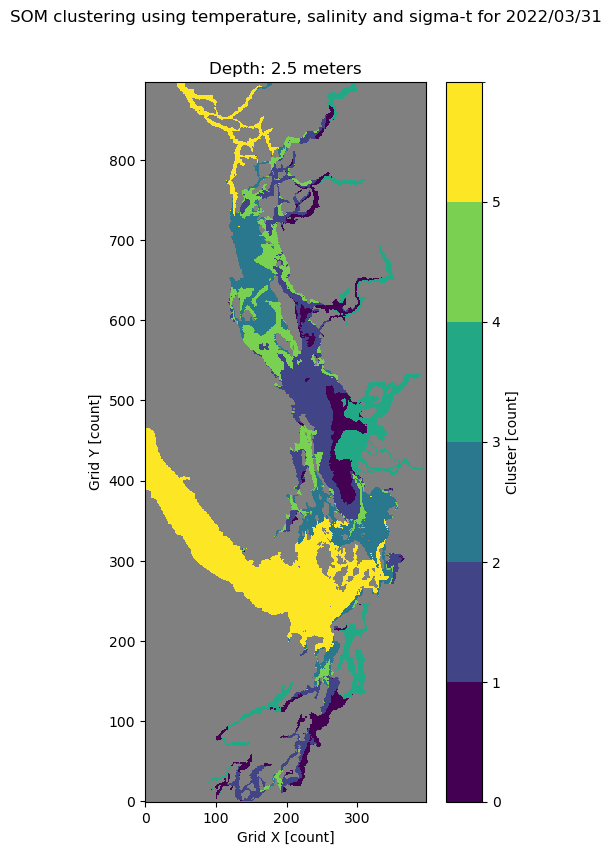

The amount of grid boxes for cluster 0 is 8109 

The minimum temperature for cluster 0 is 6.8 degrees Celsius
The maximum temperature for cluster 0 is 9.39 degrees Celsius
The mean temperature for cluster 0 is 8.26 degrees Celsius 

The minimum salinity for cluster 0 is 28.61 g/kg
The maximum salinity for cluster 0 is 29.6 g/kg
The mean salinity for cluster 0 is 29.02 g/kg 


The amount of grid boxes for cluster 1 is 15064 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 10.25 degrees Celsius
The mean temperature for cluster 1 is 8.51 degrees Celsius 

The minimum salinity for cluster 1 is 26.36 g/kg
The maximum salinity for cluster 1 is 27.75 g/kg
The mean salinity for cluster 1 is 27.14 g/kg 


The amount of grid boxes for cluster 2 is 8734 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.84 degrees Celsius
The mean temperature for cluster 2 is 8.83 degrees Celsius 

The

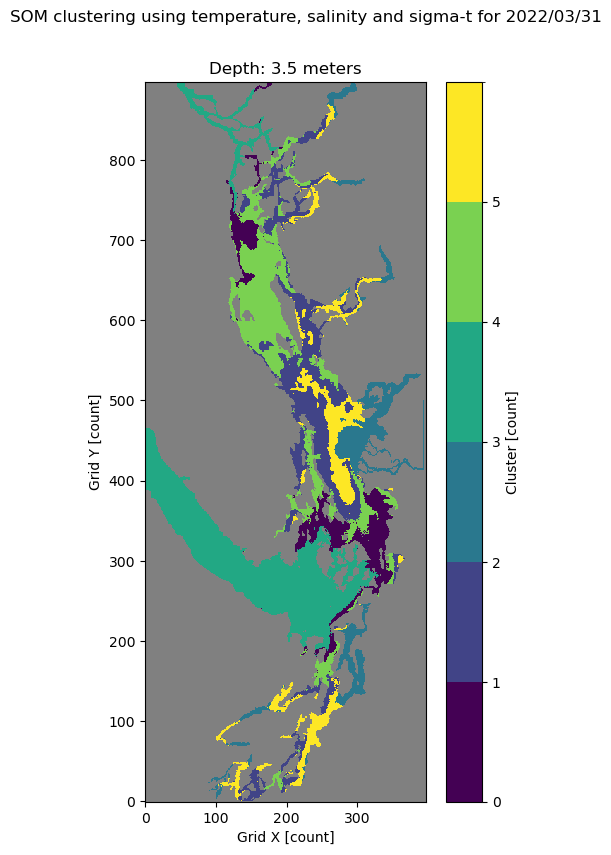

The amount of grid boxes for cluster 0 is 7290 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.68 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.99 g/kg
The mean salinity for cluster 0 is 22.1 g/kg 


The amount of grid boxes for cluster 1 is 11896 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 8.61 degrees Celsius
The mean temperature for cluster 1 is 8.12 degrees Celsius 

The minimum salinity for cluster 1 is 27.23 g/kg
The maximum salinity for cluster 1 is 28.57 g/kg
The mean salinity for cluster 1 is 28.1 g/kg 


The amount of grid boxes for cluster 2 is 25288 

The minimum temperature for cluster 2 is 6.67 degrees Celsius
The maximum temperature for cluster 2 is 9.36 degrees Celsius
The mean temperature for cluster 2 is 7.94 degrees Celsius 

The m

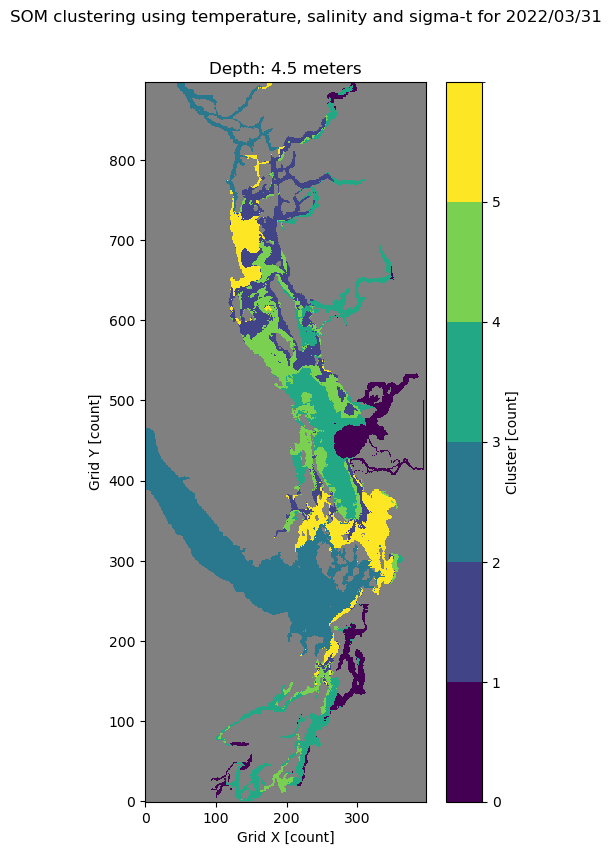

The amount of grid boxes for cluster 0 is 4693 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.99 degrees Celsius
The mean temperature for cluster 0 is 8.4 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 26.01 g/kg
The mean salinity for cluster 0 is 22.06 g/kg 


The amount of grid boxes for cluster 1 is 15826 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.19 degrees Celsius 

The minimum salinity for cluster 1 is 27.89 g/kg
The maximum salinity for cluster 1 is 28.79 g/kg
The mean salinity for cluster 1 is 28.33 g/kg 


The amount of grid boxes for cluster 2 is 23966 

The minimum temperature for cluster 2 is 6.65 degrees Celsius
The maximum temperature for cluster 2 is 9.07 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

The mi

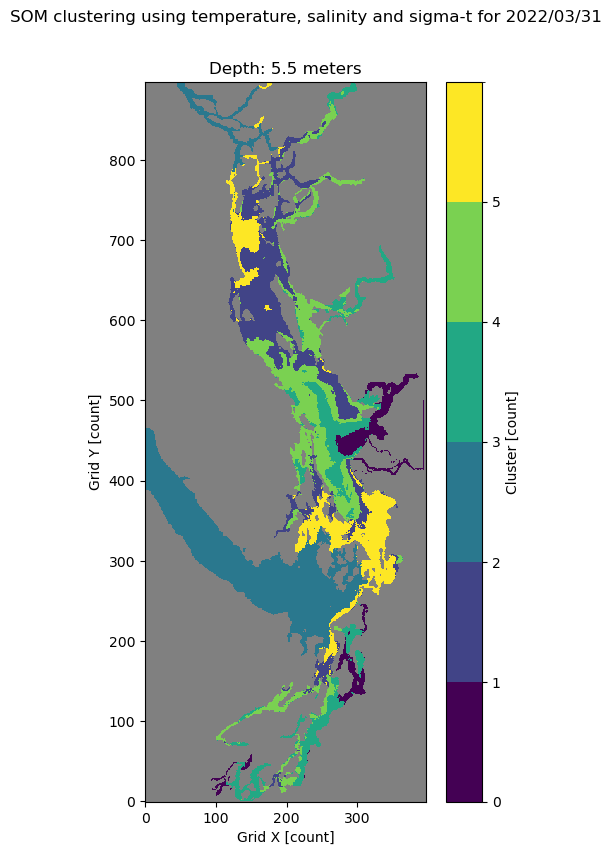

The amount of grid boxes for cluster 0 is 6192 

The minimum temperature for cluster 0 is 6.32 degrees Celsius
The maximum temperature for cluster 0 is 9.04 degrees Celsius
The mean temperature for cluster 0 is 7.97 degrees Celsius 

The minimum salinity for cluster 0 is 29.21 g/kg
The maximum salinity for cluster 0 is 30.03 g/kg
The mean salinity for cluster 0 is 29.69 g/kg 


The amount of grid boxes for cluster 1 is 14556 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.14 degrees Celsius 

The minimum salinity for cluster 1 is 28.2 g/kg
The maximum salinity for cluster 1 is 28.9 g/kg
The mean salinity for cluster 1 is 28.52 g/kg 


The amount of grid boxes for cluster 2 is 14917 

The minimum temperature for cluster 2 is 7.35 degrees Celsius
The maximum temperature for cluster 2 is 10.2 degrees Celsius
The mean temperature for cluster 2 is 8.17 degrees Celsius 

The

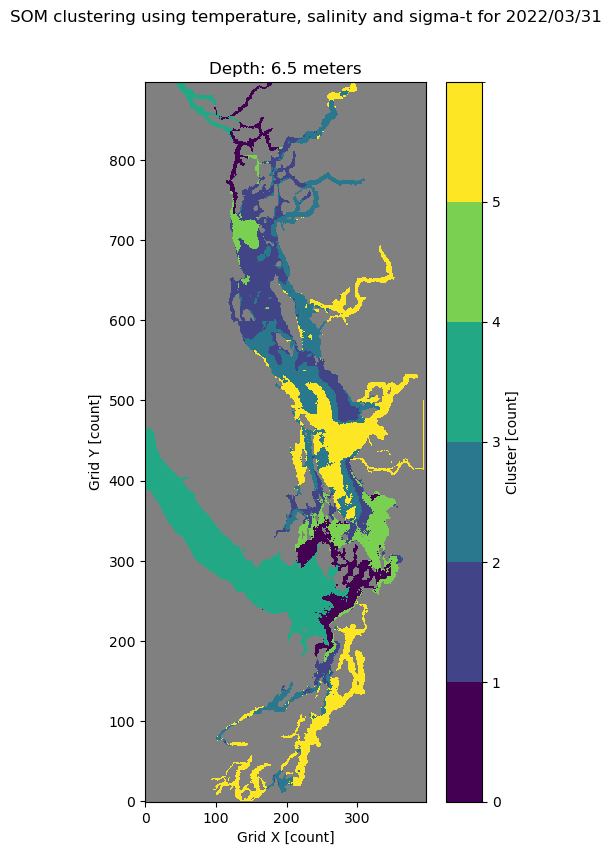

The amount of grid boxes for cluster 0 is 21509 

The minimum temperature for cluster 0 is 6.86 degrees Celsius
The maximum temperature for cluster 0 is 8.76 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 29.71 g/kg
The maximum salinity for cluster 0 is 31.44 g/kg
The mean salinity for cluster 0 is 30.63 g/kg 


The amount of grid boxes for cluster 1 is 7610 

The minimum temperature for cluster 1 is 7.79 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.21 degrees Celsius 

The minimum salinity for cluster 1 is 28.73 g/kg
The maximum salinity for cluster 1 is 29.36 g/kg
The mean salinity for cluster 1 is 28.96 g/kg 


The amount of grid boxes for cluster 2 is 15378 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.3 degrees Celsius
The mean temperature for cluster 2 is 8.41 degrees Celsius 

The

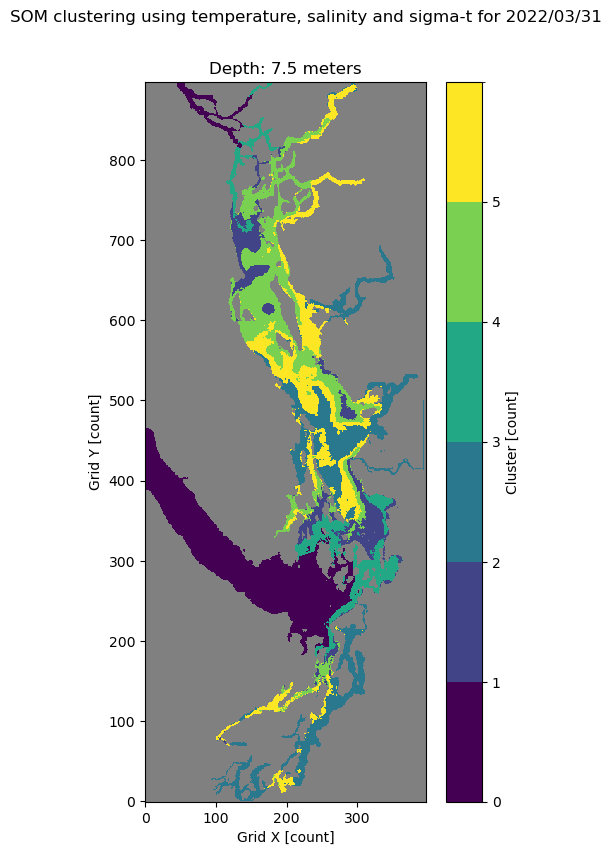

The amount of grid boxes for cluster 0 is 15239 

The minimum temperature for cluster 0 is 7.36 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.33 degrees Celsius 

The minimum salinity for cluster 0 is 27.1 g/kg
The maximum salinity for cluster 0 is 28.47 g/kg
The mean salinity for cluster 0 is 27.83 g/kg 


The amount of grid boxes for cluster 1 is 22878 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.26 degrees Celsius
The mean temperature for cluster 1 is 8.08 degrees Celsius 

The minimum salinity for cluster 1 is 28.01 g/kg
The maximum salinity for cluster 1 is 28.88 g/kg
The mean salinity for cluster 1 is 28.43 g/kg 


The amount of grid boxes for cluster 2 is 7251 

The minimum temperature for cluster 2 is 6.15 degrees Celsius
The maximum temperature for cluster 2 is 8.84 degrees Celsius
The mean temperature for cluster 2 is 8.03 degrees Celsius 

T

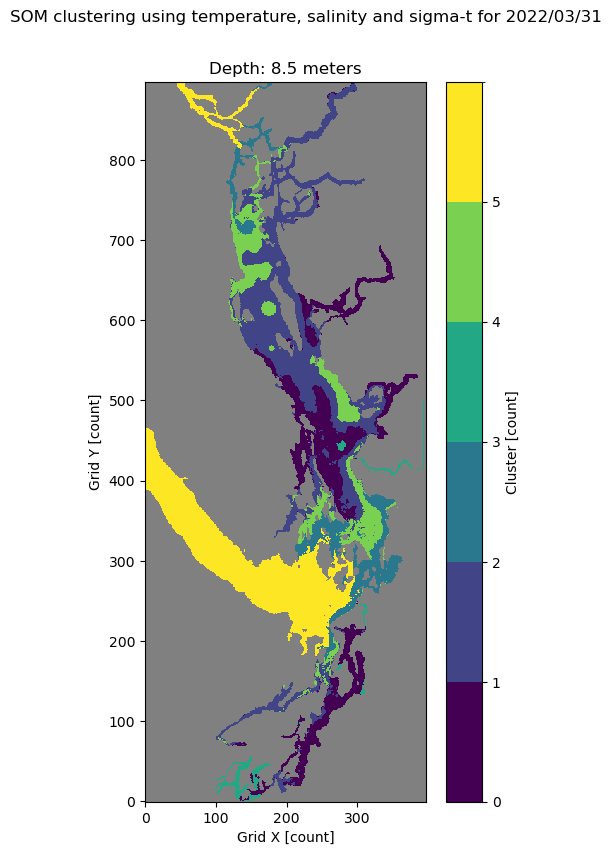

The amount of grid boxes for cluster 0 is 3107 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.29 degrees Celsius
The mean temperature for cluster 0 is 8.48 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.87 g/kg
The mean salinity for cluster 0 is 24.55 g/kg 


The amount of grid boxes for cluster 1 is 21403 

The minimum temperature for cluster 1 is 7.5 degrees Celsius
The maximum temperature for cluster 1 is 10.25 degrees Celsius
The mean temperature for cluster 1 is 8.11 degrees Celsius 

The minimum salinity for cluster 1 is 28.4 g/kg
The maximum salinity for cluster 1 is 29.16 g/kg
The mean salinity for cluster 1 is 28.63 g/kg 


The amount of grid boxes for cluster 2 is 6266 

The minimum temperature for cluster 2 is 6.16 degrees Celsius
The maximum temperature for cluster 2 is 8.63 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The mi

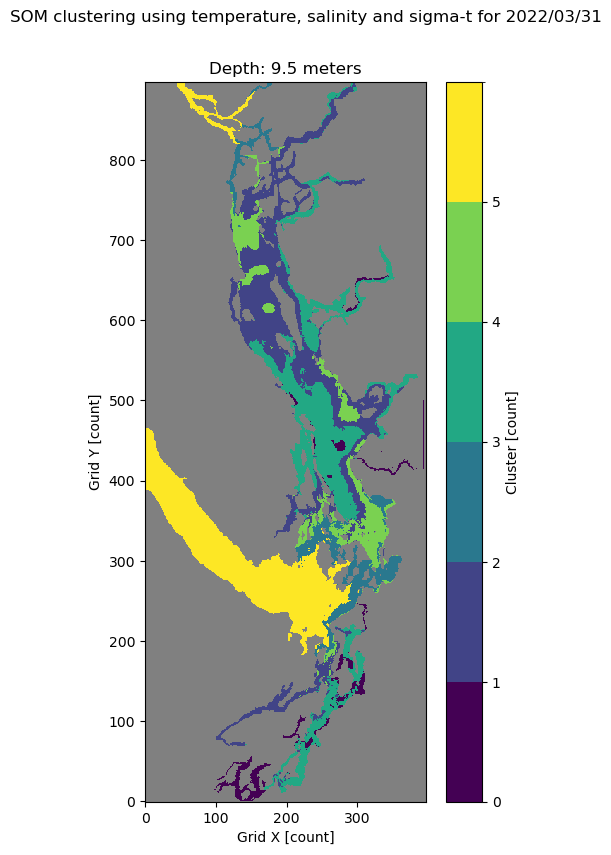

The amount of grid boxes for cluster 0 is 18542 

The minimum temperature for cluster 0 is 7.38 degrees Celsius
The maximum temperature for cluster 0 is 8.52 degrees Celsius
The mean temperature for cluster 0 is 7.92 degrees Celsius 

The minimum salinity for cluster 0 is 28.13 g/kg
The maximum salinity for cluster 0 is 28.8 g/kg
The mean salinity for cluster 0 is 28.57 g/kg 


The amount of grid boxes for cluster 1 is 6215 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.77 degrees Celsius
The mean temperature for cluster 1 is 8.08 degrees Celsius 

The minimum salinity for cluster 1 is 29.03 g/kg
The maximum salinity for cluster 1 is 29.6 g/kg
The mean salinity for cluster 1 is 29.33 g/kg 


The amount of grid boxes for cluster 2 is 18605 

The minimum temperature for cluster 2 is 7.32 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The 

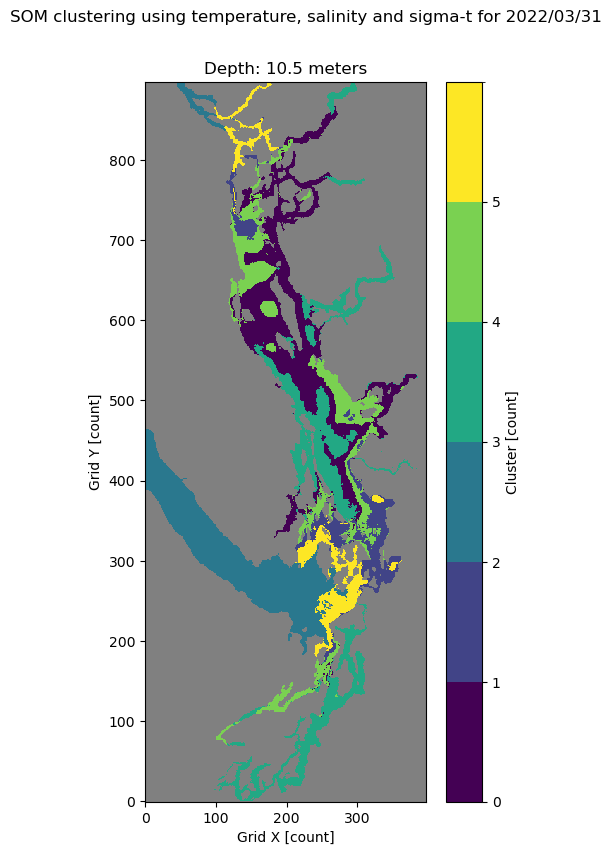

The amount of grid boxes for cluster 0 is 17775 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 30.12 g/kg
The maximum salinity for cluster 0 is 31.61 g/kg
The mean salinity for cluster 0 is 30.82 g/kg 


The amount of grid boxes for cluster 1 is 5415 

The minimum temperature for cluster 1 is 7.54 degrees Celsius
The maximum temperature for cluster 1 is 10.18 degrees Celsius
The mean temperature for cluster 1 is 8.07 degrees Celsius 

The minimum salinity for cluster 1 is 29.2 g/kg
The maximum salinity for cluster 1 is 29.7 g/kg
The mean salinity for cluster 1 is 29.41 g/kg 


The amount of grid boxes for cluster 2 is 16433 

The minimum temperature for cluster 2 is 6.41 degrees Celsius
The maximum temperature for cluster 2 is 10.43 degrees Celsius
The mean temperature for cluster 2 is 8.45 degrees Celsius 

Th

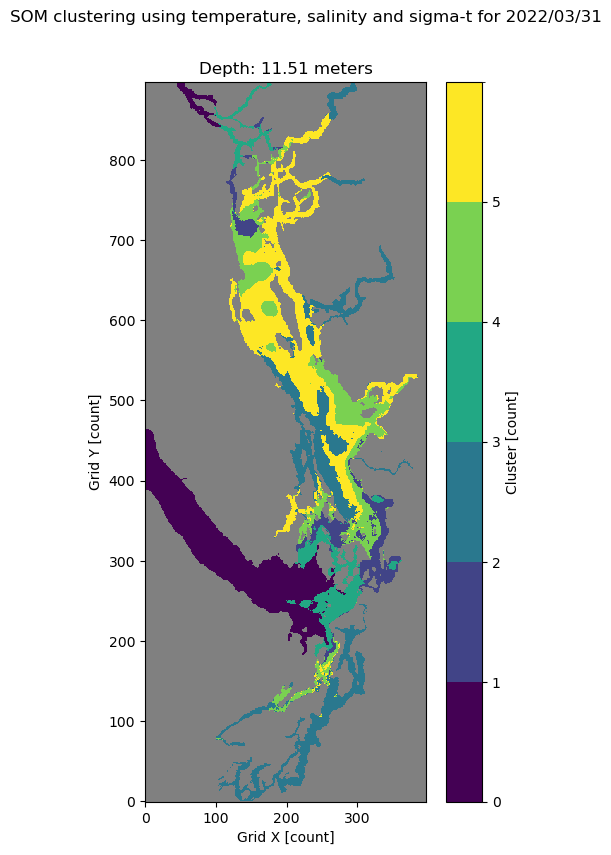

The amount of grid boxes for cluster 0 is 5544 

The minimum temperature for cluster 0 is 6.45 degrees Celsius
The maximum temperature for cluster 0 is 8.65 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 29.45 g/kg
The maximum salinity for cluster 0 is 30.06 g/kg
The mean salinity for cluster 0 is 29.78 g/kg 


The amount of grid boxes for cluster 1 is 18711 

The minimum temperature for cluster 1 is 7.63 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.17 degrees Celsius 

The minimum salinity for cluster 1 is 28.73 g/kg
The maximum salinity for cluster 1 is 29.4 g/kg
The mean salinity for cluster 1 is 28.95 g/kg 


The amount of grid boxes for cluster 2 is 8352 

The minimum temperature for cluster 2 is 6.41 degrees Celsius
The maximum temperature for cluster 2 is 10.5 degrees Celsius
The mean temperature for cluster 2 is 8.61 degrees Celsius 

The 

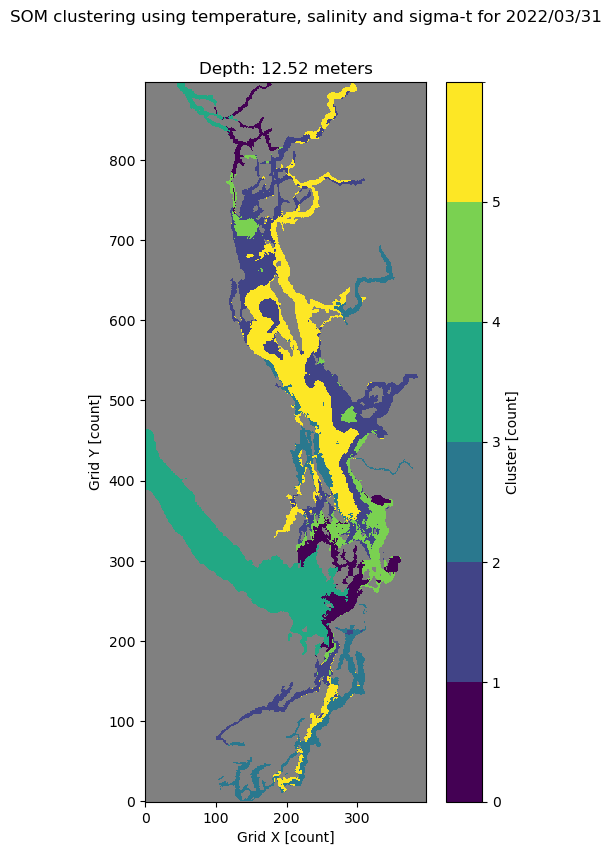

The amount of grid boxes for cluster 0 is 19275 

The minimum temperature for cluster 0 is 7.24 degrees Celsius
The maximum temperature for cluster 0 is 8.32 degrees Celsius
The mean temperature for cluster 0 is 7.84 degrees Celsius 

The minimum salinity for cluster 0 is 29.97 g/kg
The maximum salinity for cluster 0 is 31.68 g/kg
The mean salinity for cluster 0 is 30.79 g/kg 


The amount of grid boxes for cluster 1 is 6817 

The minimum temperature for cluster 1 is 7.7 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.11 degrees Celsius 

The minimum salinity for cluster 1 is 29.18 g/kg
The maximum salinity for cluster 1 is 29.65 g/kg
The mean salinity for cluster 1 is 29.34 g/kg 


The amount of grid boxes for cluster 2 is 17390 

The minimum temperature for cluster 2 is 7.49 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.35 degrees Celsius 

T

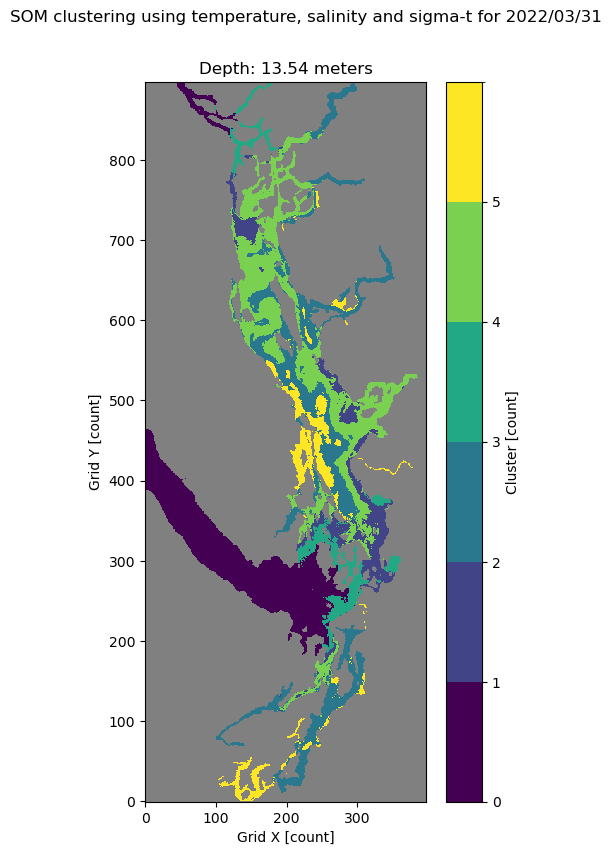

The amount of grid boxes for cluster 0 is 18276 

The minimum temperature for cluster 0 is 7.22 degrees Celsius
The maximum temperature for cluster 0 is 8.27 degrees Celsius
The mean temperature for cluster 0 is 7.83 degrees Celsius 

The minimum salinity for cluster 0 is 30.06 g/kg
The maximum salinity for cluster 0 is 31.73 g/kg
The mean salinity for cluster 0 is 30.84 g/kg 


The amount of grid boxes for cluster 1 is 7185 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.06 degrees Celsius 

The minimum salinity for cluster 1 is 29.21 g/kg
The maximum salinity for cluster 1 is 29.73 g/kg
The mean salinity for cluster 1 is 29.41 g/kg 


The amount of grid boxes for cluster 2 is 22955 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 10.47 degrees Celsius
The mean temperature for cluster 2 is 8.17 degrees Celsius 



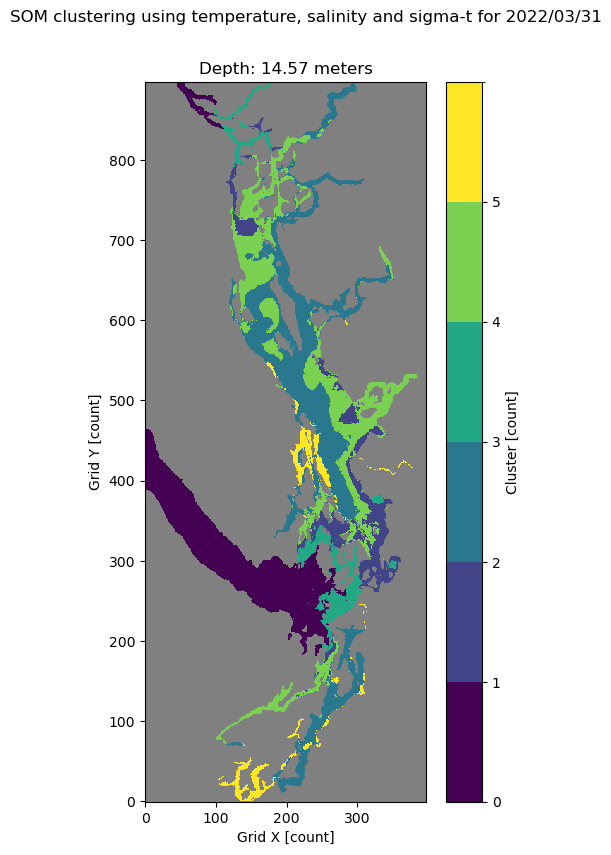

The amount of grid boxes for cluster 0 is 10535 

The minimum temperature for cluster 0 is 8.1 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.77 degrees Celsius 

The minimum salinity for cluster 0 is 27.44 g/kg
The maximum salinity for cluster 0 is 29.6 g/kg
The mean salinity for cluster 0 is 28.86 g/kg 


The amount of grid boxes for cluster 1 is 11449 

The minimum temperature for cluster 1 is 7.84 degrees Celsius
The maximum temperature for cluster 1 is 9.0 degrees Celsius
The mean temperature for cluster 1 is 8.2 degrees Celsius 

The minimum salinity for cluster 1 is 29.04 g/kg
The maximum salinity for cluster 1 is 29.79 g/kg
The mean salinity for cluster 1 is 29.21 g/kg 


The amount of grid boxes for cluster 2 is 5073 

The minimum temperature for cluster 2 is 6.8 degrees Celsius
The maximum temperature for cluster 2 is 8.66 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The mi

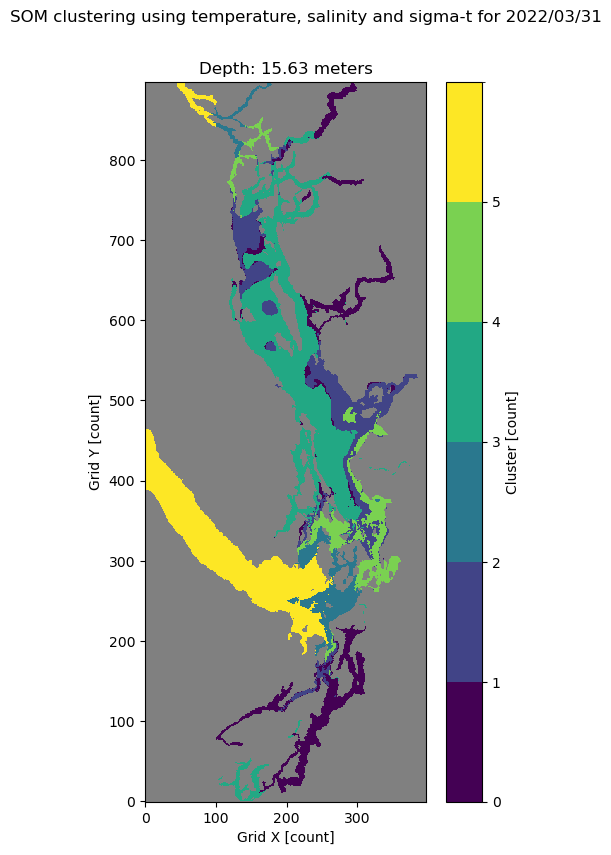

The amount of grid boxes for cluster 0 is 4768 

The minimum temperature for cluster 0 is 6.93 degrees Celsius
The maximum temperature for cluster 0 is 8.19 degrees Celsius
The mean temperature for cluster 0 is 7.86 degrees Celsius 

The minimum salinity for cluster 0 is 29.8 g/kg
The maximum salinity for cluster 0 is 30.34 g/kg
The mean salinity for cluster 0 is 30.08 g/kg 


The amount of grid boxes for cluster 1 is 10840 

The minimum temperature for cluster 1 is 7.7 degrees Celsius
The maximum temperature for cluster 1 is 8.68 degrees Celsius
The mean temperature for cluster 1 is 8.14 degrees Celsius 

The minimum salinity for cluster 1 is 29.09 g/kg
The maximum salinity for cluster 1 is 29.51 g/kg
The mean salinity for cluster 1 is 29.3 g/kg 


The amount of grid boxes for cluster 2 is 21586 

The minimum temperature for cluster 2 is 6.48 degrees Celsius
The maximum temperature for cluster 2 is 9.14 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The m

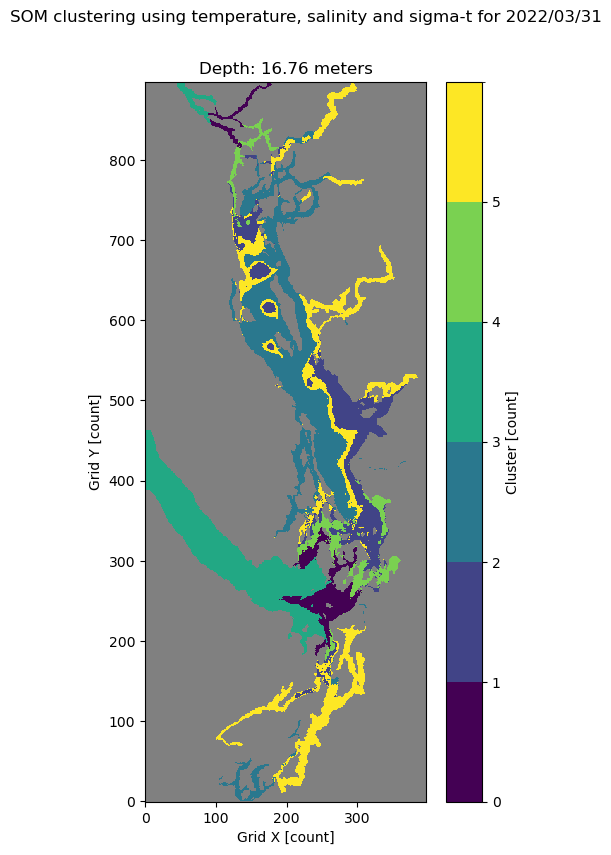

The amount of grid boxes for cluster 0 is 4986 

The minimum temperature for cluster 0 is 7.06 degrees Celsius
The maximum temperature for cluster 0 is 8.2 degrees Celsius
The mean temperature for cluster 0 is 7.86 degrees Celsius 

The minimum salinity for cluster 0 is 29.79 g/kg
The maximum salinity for cluster 0 is 30.37 g/kg
The mean salinity for cluster 0 is 30.09 g/kg 


The amount of grid boxes for cluster 1 is 11221 

The minimum temperature for cluster 1 is 7.82 degrees Celsius
The maximum temperature for cluster 1 is 8.76 degrees Celsius
The mean temperature for cluster 1 is 8.18 degrees Celsius 

The minimum salinity for cluster 1 is 29.16 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 29.33 g/kg 


The amount of grid boxes for cluster 2 is 12069 

The minimum temperature for cluster 2 is 8.09 degrees Celsius
The maximum temperature for cluster 2 is 10.42 degrees Celsius
The mean temperature for cluster 2 is 8.73 degrees Celsius 

Th

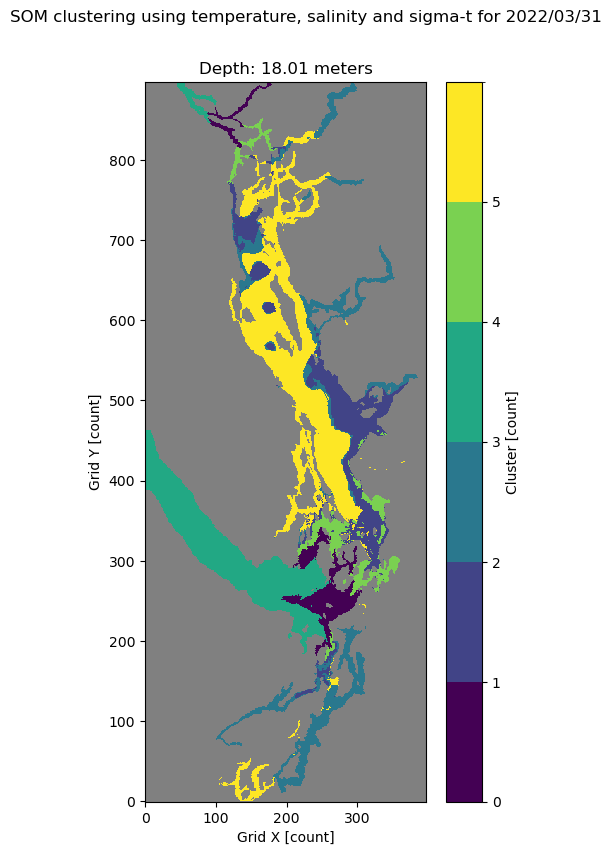

The amount of grid boxes for cluster 0 is 15795 

The minimum temperature for cluster 0 is 7.15 degrees Celsius
The maximum temperature for cluster 0 is 8.18 degrees Celsius
The mean temperature for cluster 0 is 7.77 degrees Celsius 

The minimum salinity for cluster 0 is 30.38 g/kg
The maximum salinity for cluster 0 is 31.97 g/kg
The mean salinity for cluster 0 is 31.0 g/kg 


The amount of grid boxes for cluster 1 is 5333 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.4 degrees Celsius
The mean temperature for cluster 1 is 7.94 degrees Celsius 

The minimum salinity for cluster 1 is 29.32 g/kg
The maximum salinity for cluster 1 is 29.95 g/kg
The mean salinity for cluster 1 is 29.63 g/kg 


The amount of grid boxes for cluster 2 is 25312 

The minimum temperature for cluster 2 is 6.49 degrees Celsius
The maximum temperature for cluster 2 is 8.53 degrees Celsius
The mean temperature for cluster 2 is 7.99 degrees Celsius 

The 

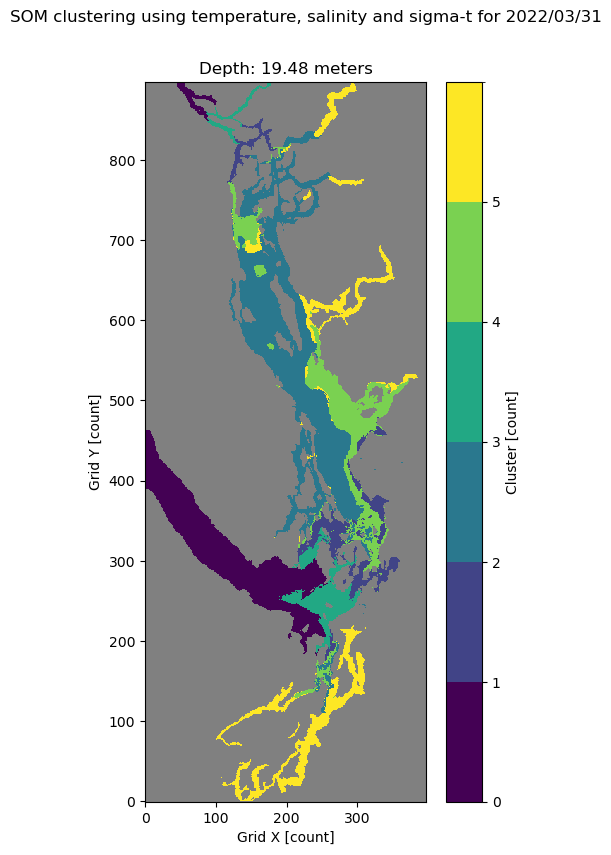

The amount of grid boxes for cluster 0 is 14325 

The minimum temperature for cluster 0 is 7.14 degrees Celsius
The maximum temperature for cluster 0 is 8.17 degrees Celsius
The mean temperature for cluster 0 is 7.75 degrees Celsius 

The minimum salinity for cluster 0 is 30.56 g/kg
The maximum salinity for cluster 0 is 32.1 g/kg
The mean salinity for cluster 0 is 31.08 g/kg 


The amount of grid boxes for cluster 1 is 4860 

The minimum temperature for cluster 1 is 7.46 degrees Celsius
The maximum temperature for cluster 1 is 8.32 degrees Celsius
The mean temperature for cluster 1 is 7.89 degrees Celsius 

The minimum salinity for cluster 1 is 29.41 g/kg
The maximum salinity for cluster 1 is 30.09 g/kg
The mean salinity for cluster 1 is 29.78 g/kg 


The amount of grid boxes for cluster 2 is 24432 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 9.04 degrees Celsius
The mean temperature for cluster 2 is 8.03 degrees Celsius 

The

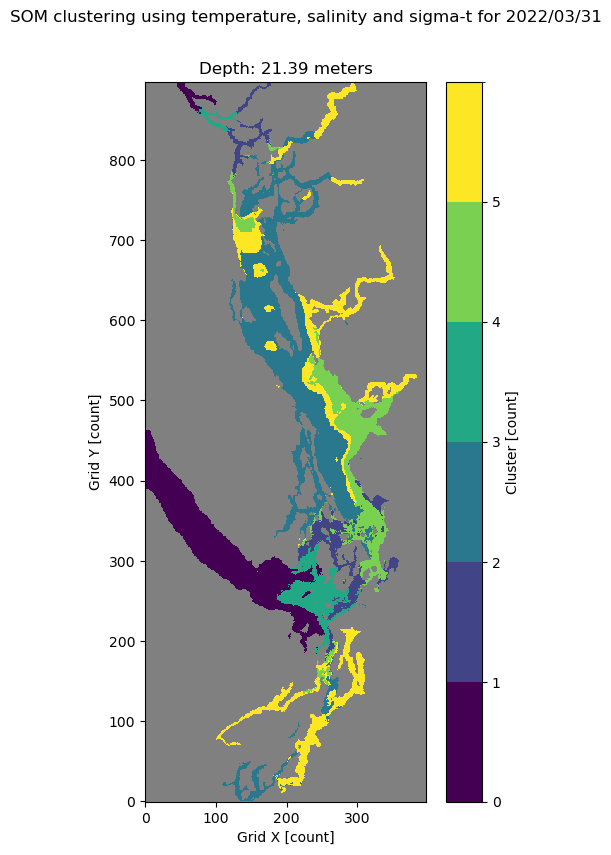

The amount of grid boxes for cluster 0 is 3905 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 8.28 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 29.96 g/kg
The maximum salinity for cluster 0 is 30.49 g/kg
The mean salinity for cluster 0 is 30.19 g/kg 


The amount of grid boxes for cluster 1 is 9628 

The minimum temperature for cluster 1 is 7.99 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.63 degrees Celsius 

The minimum salinity for cluster 1 is 29.43 g/kg
The maximum salinity for cluster 1 is 29.91 g/kg
The mean salinity for cluster 1 is 29.58 g/kg 


The amount of grid boxes for cluster 2 is 12878 

The minimum temperature for cluster 2 is 7.94 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 8.45 degrees Celsius 

Th

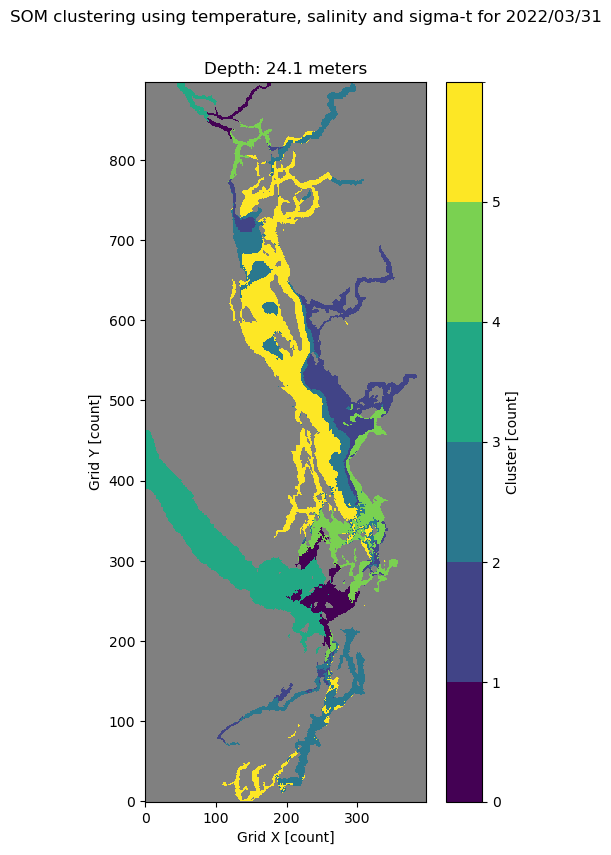

The amount of grid boxes for cluster 0 is 14698 

The minimum temperature for cluster 0 is 7.92 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.46 degrees Celsius 

The minimum salinity for cluster 0 is 28.78 g/kg
The maximum salinity for cluster 0 is 29.78 g/kg
The mean salinity for cluster 0 is 29.35 g/kg 


The amount of grid boxes for cluster 1 is 9315 

The minimum temperature for cluster 1 is 8.01 degrees Celsius
The maximum temperature for cluster 1 is 9.92 degrees Celsius
The mean temperature for cluster 1 is 8.62 degrees Celsius 

The minimum salinity for cluster 1 is 29.48 g/kg
The maximum salinity for cluster 1 is 30.25 g/kg
The mean salinity for cluster 1 is 29.69 g/kg 


The amount of grid boxes for cluster 2 is 3914 

The minimum temperature for cluster 2 is 7.42 degrees Celsius
The maximum temperature for cluster 2 is 8.01 degrees Celsius
The mean temperature for cluster 2 is 7.81 degrees Celsius 

Th

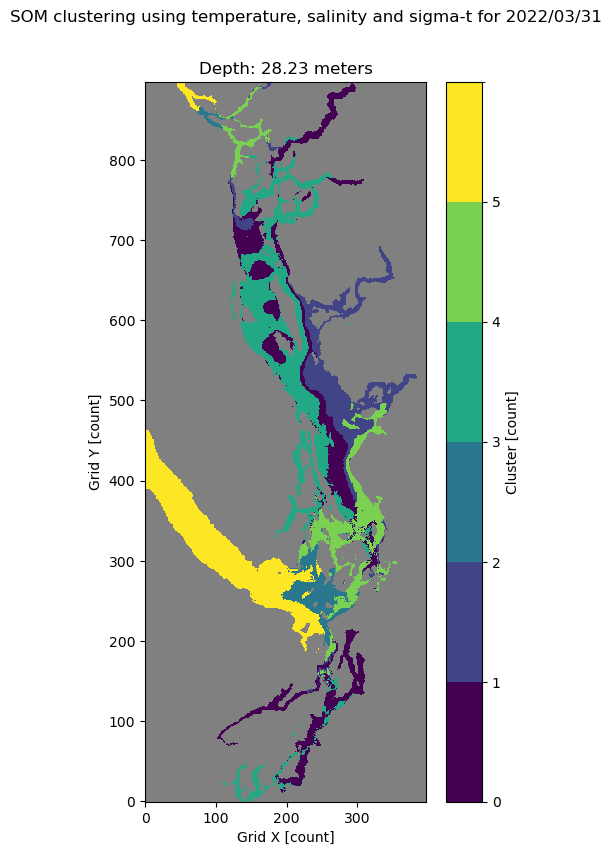

The amount of grid boxes for cluster 0 is 12512 

The minimum temperature for cluster 0 is 8.23 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.81 degrees Celsius 

The minimum salinity for cluster 0 is 28.78 g/kg
The maximum salinity for cluster 0 is 30.02 g/kg
The mean salinity for cluster 0 is 29.7 g/kg 


The amount of grid boxes for cluster 1 is 2622 

The minimum temperature for cluster 1 is 7.32 degrees Celsius
The maximum temperature for cluster 1 is 8.92 degrees Celsius
The mean temperature for cluster 1 is 7.87 degrees Celsius 

The minimum salinity for cluster 1 is 29.92 g/kg
The maximum salinity for cluster 1 is 30.39 g/kg
The mean salinity for cluster 1 is 30.14 g/kg 


The amount of grid boxes for cluster 2 is 12759 

The minimum temperature for cluster 2 is 7.13 degrees Celsius
The maximum temperature for cluster 2 is 7.87 degrees Celsius
The mean temperature for cluster 2 is 7.63 degrees Celsius 

Th

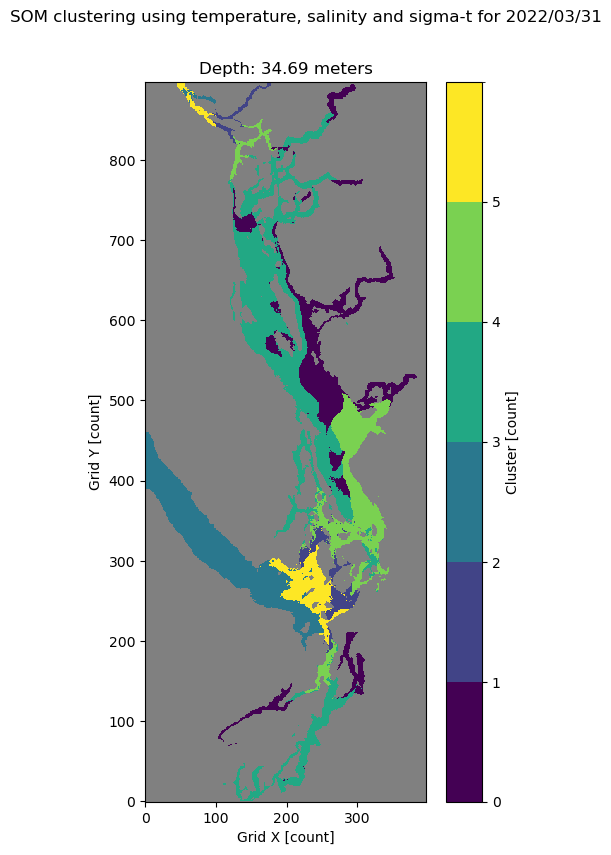

The amount of grid boxes for cluster 0 is 12084 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 7.78 degrees Celsius
The mean temperature for cluster 0 is 7.56 degrees Celsius 

The minimum salinity for cluster 0 is 31.05 g/kg
The maximum salinity for cluster 0 is 32.93 g/kg
The mean salinity for cluster 0 is 31.69 g/kg 


The amount of grid boxes for cluster 1 is 1567 

The minimum temperature for cluster 1 is 7.52 degrees Celsius
The maximum temperature for cluster 1 is 9.02 degrees Celsius
The mean temperature for cluster 1 is 7.9 degrees Celsius 

The minimum salinity for cluster 1 is 30.11 g/kg
The maximum salinity for cluster 1 is 30.51 g/kg
The mean salinity for cluster 1 is 30.27 g/kg 


The amount of grid boxes for cluster 2 is 13255 

The minimum temperature for cluster 2 is 8.34 degrees Celsius
The maximum temperature for cluster 2 is 10.31 degrees Celsius
The mean temperature for cluster 2 is 8.83 degrees Celsius 

Th

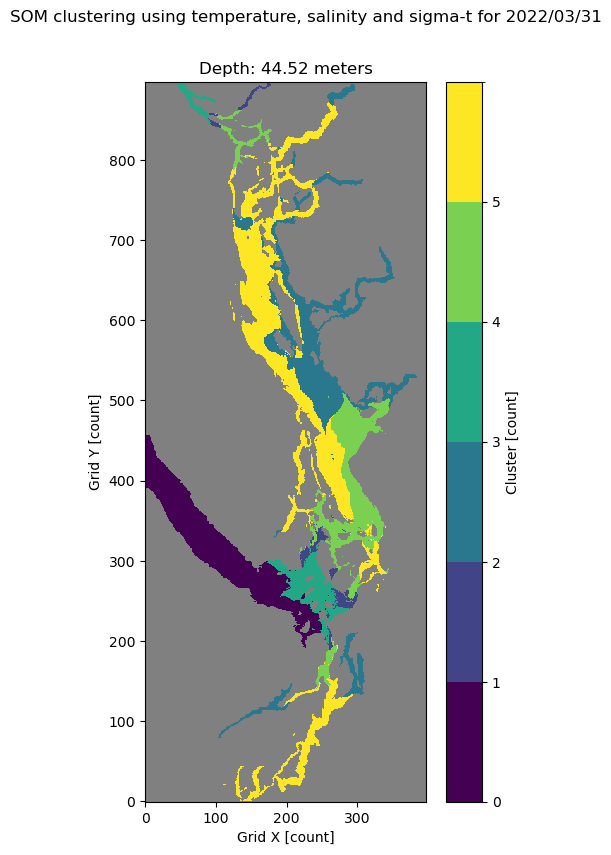

The amount of grid boxes for cluster 0 is 11869 

The minimum temperature for cluster 0 is 7.29 degrees Celsius
The maximum temperature for cluster 0 is 7.71 degrees Celsius
The mean temperature for cluster 0 is 7.48 degrees Celsius 

The minimum salinity for cluster 0 is 31.21 g/kg
The maximum salinity for cluster 0 is 33.17 g/kg
The mean salinity for cluster 0 is 32.06 g/kg 


The amount of grid boxes for cluster 1 is 872 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.88 degrees Celsius
The mean temperature for cluster 1 is 7.85 degrees Celsius 

The minimum salinity for cluster 1 is 30.21 g/kg
The maximum salinity for cluster 1 is 30.54 g/kg
The mean salinity for cluster 1 is 30.34 g/kg 


The amount of grid boxes for cluster 2 is 16344 

The minimum temperature for cluster 2 is 8.36 degrees Celsius
The maximum temperature for cluster 2 is 10.39 degrees Celsius
The mean temperature for cluster 2 is 8.81 degrees Celsius 

Th

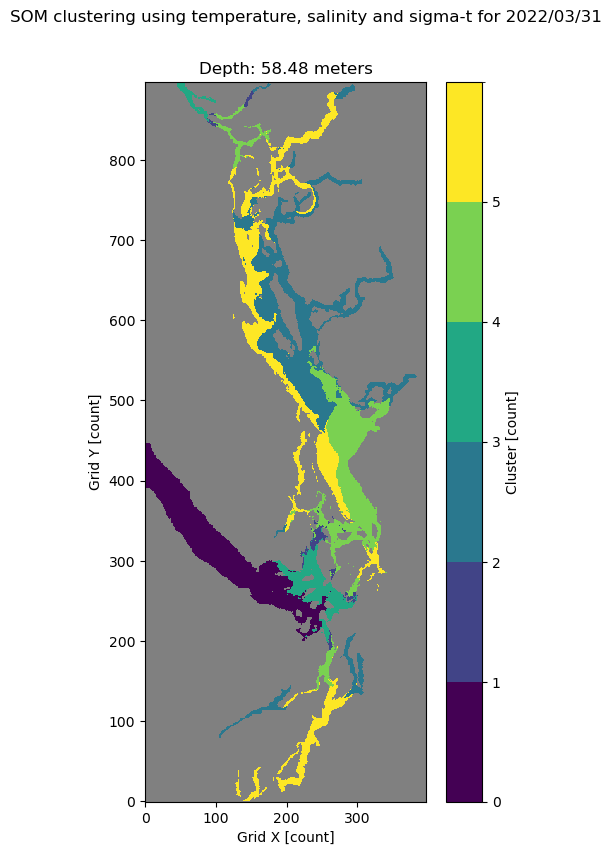

The amount of grid boxes for cluster 0 is 21264 

The minimum temperature for cluster 0 is 8.33 degrees Celsius
The maximum temperature for cluster 0 is 10.45 degrees Celsius
The mean temperature for cluster 0 is 8.78 degrees Celsius 

The minimum salinity for cluster 0 is 27.51 g/kg
The maximum salinity for cluster 0 is 30.53 g/kg
The mean salinity for cluster 0 is 29.98 g/kg 


The amount of grid boxes for cluster 1 is 564 

The minimum temperature for cluster 1 is 7.61 degrees Celsius
The maximum temperature for cluster 1 is 8.84 degrees Celsius
The mean temperature for cluster 1 is 7.87 degrees Celsius 

The minimum salinity for cluster 1 is 30.21 g/kg
The maximum salinity for cluster 1 is 30.46 g/kg
The mean salinity for cluster 1 is 30.32 g/kg 


The amount of grid boxes for cluster 2 is 2722 

The minimum temperature for cluster 2 is 7.41 degrees Celsius
The maximum temperature for cluster 2 is 7.67 degrees Celsius
The mean temperature for cluster 2 is 7.52 degrees Celsius 

The

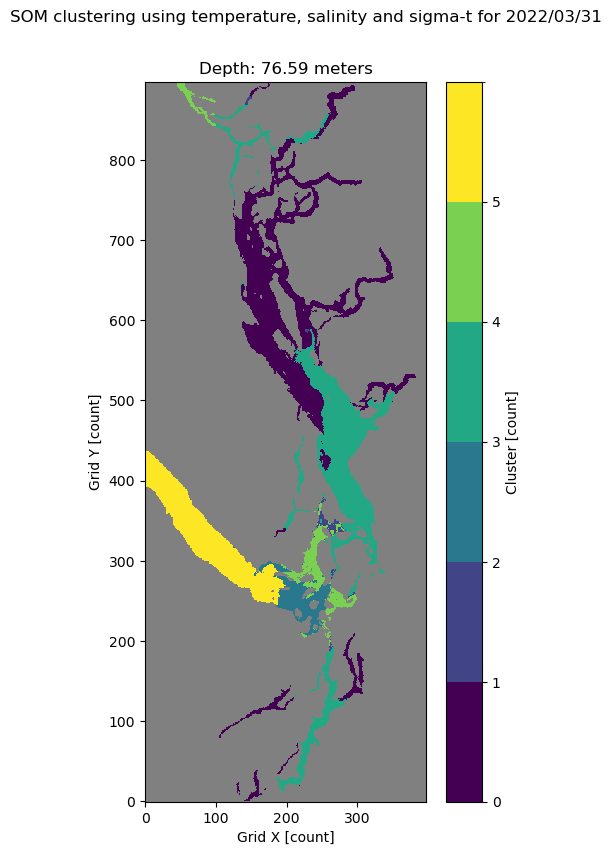

The amount of grid boxes for cluster 0 is 17845 

The minimum temperature for cluster 0 is 8.35 degrees Celsius
The maximum temperature for cluster 0 is 10.48 degrees Celsius
The mean temperature for cluster 0 is 8.88 degrees Celsius 

The minimum salinity for cluster 0 is 29.51 g/kg
The maximum salinity for cluster 0 is 30.57 g/kg
The mean salinity for cluster 0 is 30.19 g/kg 


The amount of grid boxes for cluster 1 is 1132 

The minimum temperature for cluster 1 is 7.27 degrees Celsius
The maximum temperature for cluster 1 is 7.83 degrees Celsius
The mean temperature for cluster 1 is 7.65 degrees Celsius 

The minimum salinity for cluster 1 is 30.69 g/kg
The maximum salinity for cluster 1 is 31.24 g/kg
The mean salinity for cluster 1 is 30.94 g/kg 


The amount of grid boxes for cluster 2 is 8500 

The minimum temperature for cluster 2 is 7.07 degrees Celsius
The maximum temperature for cluster 2 is 7.5 degrees Celsius
The mean temperature for cluster 2 is 7.22 degrees Celsius 

The

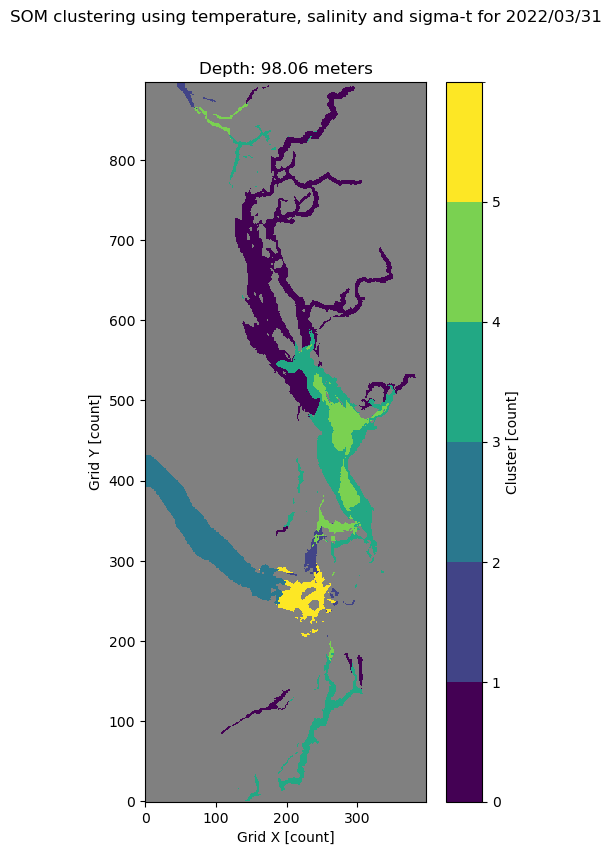

The amount of grid boxes for cluster 0 is 1660 

The minimum temperature for cluster 0 is 7.27 degrees Celsius
The maximum temperature for cluster 0 is 7.5 degrees Celsius
The mean temperature for cluster 0 is 7.4 degrees Celsius 

The minimum salinity for cluster 0 is 31.71 g/kg
The maximum salinity for cluster 0 is 32.82 g/kg
The mean salinity for cluster 0 is 32.17 g/kg 


The amount of grid boxes for cluster 1 is 1281 

The minimum temperature for cluster 1 is 7.29 degrees Celsius
The maximum temperature for cluster 1 is 7.89 degrees Celsius
The mean temperature for cluster 1 is 7.65 degrees Celsius 

The minimum salinity for cluster 1 is 30.21 g/kg
The maximum salinity for cluster 1 is 31.09 g/kg
The mean salinity for cluster 1 is 30.81 g/kg 


The amount of grid boxes for cluster 2 is 15368 

The minimum temperature for cluster 2 is 7.42 degrees Celsius
The maximum temperature for cluster 2 is 8.58 degrees Celsius
The mean temperature for cluster 2 is 8.0 degrees Celsius 

The mi

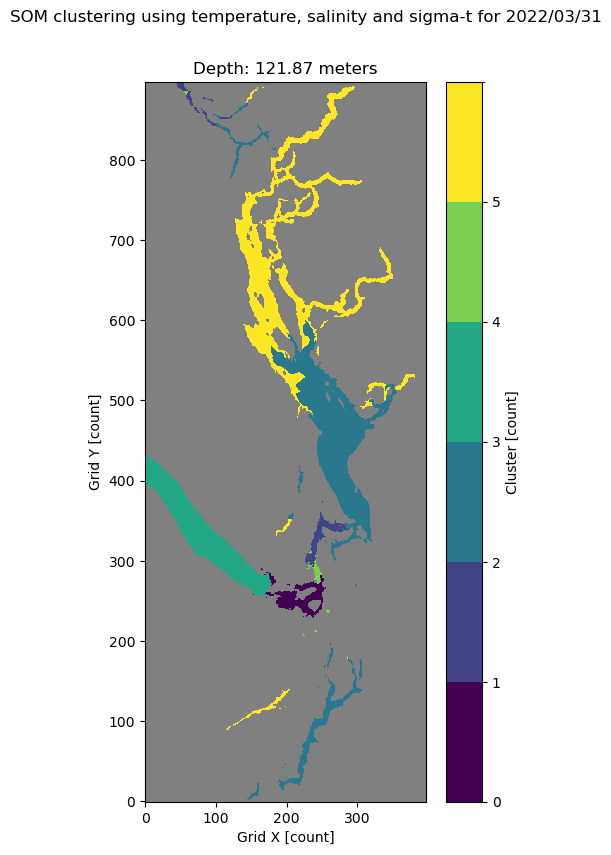

The amount of grid boxes for cluster 0 is 13701 

The minimum temperature for cluster 0 is 8.51 degrees Celsius
The maximum temperature for cluster 0 is 10.78 degrees Celsius
The mean temperature for cluster 0 is 9.05 degrees Celsius 

The minimum salinity for cluster 0 is 29.81 g/kg
The maximum salinity for cluster 0 is 30.87 g/kg
The mean salinity for cluster 0 is 30.54 g/kg 


The amount of grid boxes for cluster 1 is 87 

The minimum temperature for cluster 1 is 7.49 degrees Celsius
The maximum temperature for cluster 1 is 7.62 degrees Celsius
The mean temperature for cluster 1 is 7.53 degrees Celsius 

The minimum salinity for cluster 1 is 31.25 g/kg
The maximum salinity for cluster 1 is 31.76 g/kg
The mean salinity for cluster 1 is 31.57 g/kg 


The amount of grid boxes for cluster 2 is 6018 

The minimum temperature for cluster 2 is 6.83 degrees Celsius
The maximum temperature for cluster 2 is 7.27 degrees Celsius
The mean temperature for cluster 2 is 7.06 degrees Celsius 

The 

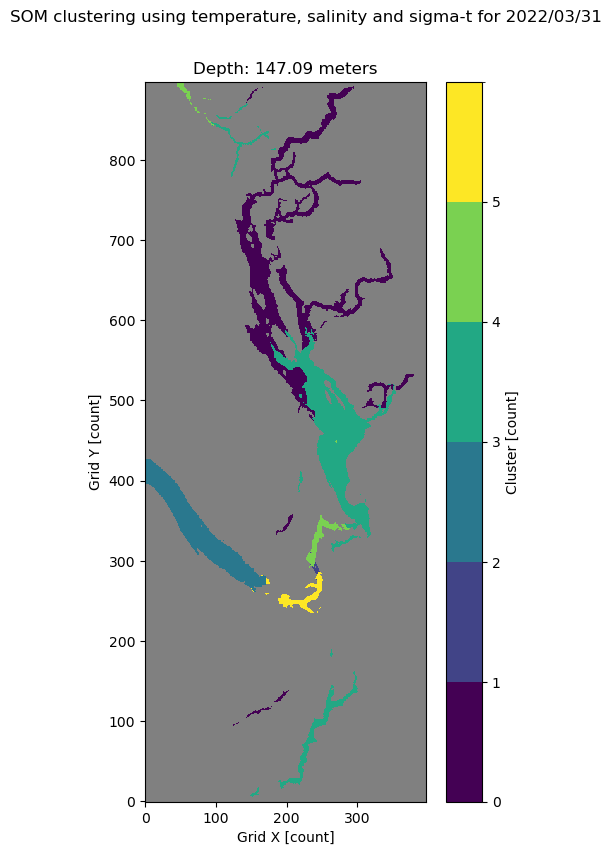

The amount of grid boxes for cluster 0 is 11836 

The minimum temperature for cluster 0 is 8.79 degrees Celsius
The maximum temperature for cluster 0 is 10.8 degrees Celsius
The mean temperature for cluster 0 is 9.15 degrees Celsius 

The minimum salinity for cluster 0 is 30.15 g/kg
The maximum salinity for cluster 0 is 30.92 g/kg
The mean salinity for cluster 0 is 30.66 g/kg 


The amount of grid boxes for cluster 2 is 1989 

The minimum temperature for cluster 2 is 6.72 degrees Celsius
The maximum temperature for cluster 2 is 7.4 degrees Celsius
The mean temperature for cluster 2 is 7.0 degrees Celsius 

The minimum salinity for cluster 2 is 32.17 g/kg
The maximum salinity for cluster 2 is 33.84 g/kg
The mean salinity for cluster 2 is 33.59 g/kg 


The amount of grid boxes for cluster 3 is 8530 

The minimum temperature for cluster 3 is 8.24 degrees Celsius
The maximum temperature for cluster 3 is 8.85 degrees Celsius
The mean temperature for cluster 3 is 8.6 degrees Celsius 

The mi

IndexError: index 5 is out of bounds for axis 0 with size 5

In [7]:
ds, temp, saline, sigma, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sigma= masking(depth, temp, saline, sigma,  mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline, sigma)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
